## Import

In [1]:
# === Standard Library ===
import os
import warnings

# === Computing & Visualization ===
import torch
import pandas as pd
import numpy as np

# === Warning Suppression ===
from tqdm import TqdmWarning
warnings.simplefilter("ignore", category=TqdmWarning)
warnings.filterwarnings("ignore", message="TypedStorage is deprecated")
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="Some weights of RobertaModel were not initialized")
from transformers.utils import logging
logging.set_verbosity_error()

# === Model Architectures ===
from models.Emb2Profile import SigmaProfileGenerator
from models.Emb2Geometry import GeometryGenerator
from models.Prf2Gamma import Prf_to_Seg_Model

# === Model Loading ===
from utils.model_io import load_model, load_all_Gamma_models

# === Embedding Extraction ===

from utils.embedding import ChemBERTaEmbedder, SMITEDEmbedder

# === Computation ===
from utils.property import get_sigma_profile, calc_ln_gamma, ensemble_segac, calc_ln_gamma_binary

# === Poltting ===
from utils.plotting import plot_sigma_prf, plot_sigma_prf_pair, plot_binary_lng


In [2]:
import sys
print(sys.version)       # Python 的版本號
print(sys.executable)    # Python 執行檔路徑

3.11.11 | packaged by conda-forge | (main, Mar  3 2025, 20:29:43) [MSC v.1943 64 bit (AMD64)]
c:\Users\Yang\anaconda3\envs\PINN-SAC\python.exe


In [3]:
import torch
print(torch.__version__)


2.1.2+cpu


## Load models

In [4]:
cb_emb = ChemBERTaEmbedder()
st_emb = SMITEDEmbedder()

ckpt_path = "./ckpt_files"
prf_model = load_model(SigmaProfileGenerator(), os.path.join(ckpt_path, "prf.ckpt"))
geometry_model = load_model(GeometryGenerator(), os.path.join(ckpt_path, "geo.ckpt"))
Gamma_base_model = load_model(Prf_to_Seg_Model(), os.path.join(ckpt_path, "base.ckpt"))

Gamma_finetuned_models = load_all_Gamma_models(Prf_to_Seg_Model, os.path.join(ckpt_path, "fine-tuned"))

## Functions

In [5]:
def sigma_profile_wrapper(smiles):
    return get_sigma_profile(smiles, prf_model, geometry_model, cb_emb, st_emb)

def single_model_predictor(sigma, temperature):
    return Gamma_base_model(sigma, torch.tensor([temperature]))[1]

def ensemble_predictor(sigma, temperature):
    return ensemble_segac(Gamma_finetuned_models, sigma, temperature)

def report_binary_result(smiles_1, smiles_2, x1_list, temperature, ln_gamma_1, ln_gamma_2,
                        get_sigma_profile_fn, savepath=None):

    prf_1, area_1, volume_1 = get_sigma_profile_fn(smiles_1)
    prf_2, area_2, volume_2 = get_sigma_profile_fn(smiles_2)

    plot_binary_lng(x1_list, temperature, ln_gamma_1, ln_gamma_2, smiles_1, smiles_2, savepath=savepath)

    print(f"{smiles_1}")
    print(f"  Surface Area    : {area_1:.2f} Å²")
    print(f"  Molecular Volume: {volume_1:.2f} Å³")

    print(f"{smiles_2}")
    print(f"  Surface Area    : {area_2:.2f} Å²")
    print(f"  Molecular Volume: {volume_2:.2f} Å³")

    plot_sigma_prf_pair(smiles_1, prf_1, smiles_2, prf_2)

def report_ln_gamma(smiles_list, mole_fraction_list, ln_gamma_array, temperature):
    num_components = len(smiles_list)

    if len(mole_fraction_list) == num_components - 1:
        last_mf = 1.0 - sum(mole_fraction_list)
        if last_mf < 0 or last_mf > 1:
            raise ValueError(f"Invalid mole fractions: sum = {sum(mole_fraction_list):.4f}")
        mole_fraction_list = mole_fraction_list + [last_mf]
    elif len(mole_fraction_list) == num_components:
        mf_sum = sum(mole_fraction_list)
        if abs(mf_sum - 1.0) > 1e-6:
            raise ValueError(f"Mole fractions must sum to 1.0, but got {mf_sum:.6f}")
    else:
        raise ValueError(f"Length mismatch: {num_components} SMILES vs {len(mole_fraction_list)} mole fractions.")

    df = pd.DataFrame({
        "SMILES": smiles_list,
        "Mole Fraction": [round(x, 4) for x in mole_fraction_list],
        "ln γ": [round(lng, 4) for lng in ln_gamma_array]
    })

    print(f"=== ln γ at T = {temperature:.2f} K ===")
    display(df)
    return df

# σ-Profile Prediction

Surface Area    : 154.17 Å²
Molecular Volume: 139.42 Å³


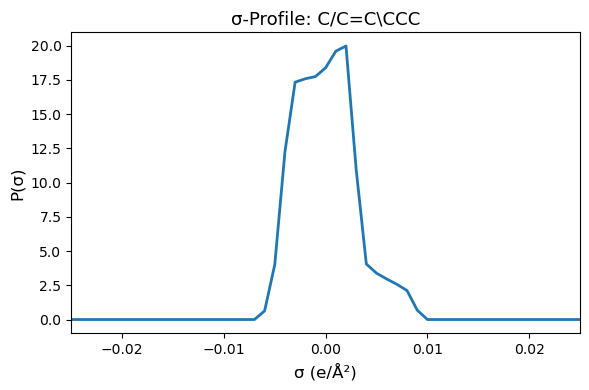

In [6]:
smiles = 'C/C=C\CCC'

prf, area, volume = sigma_profile_wrapper(smiles)
print(f"Surface Area    : {area:.2f} Å²")
print(f"Molecular Volume: {volume:.2f} Å³")
plot_sigma_prf(smiles, prf)

# Activity Coefficient Prediction

## Binary System

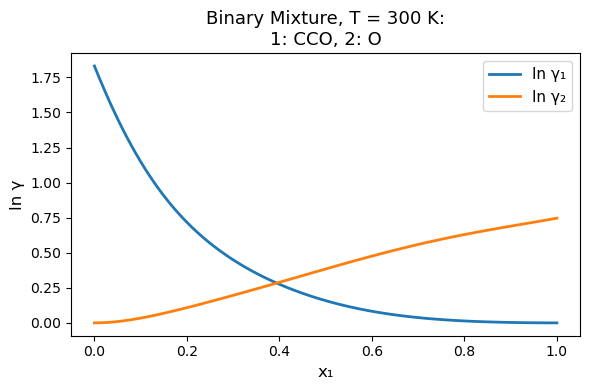

CCO
  Surface Area    : 89.52 Å²
  Molecular Volume: 70.53 Å³
O
  Surface Area    : 42.99 Å²
  Molecular Volume: 25.55 Å³


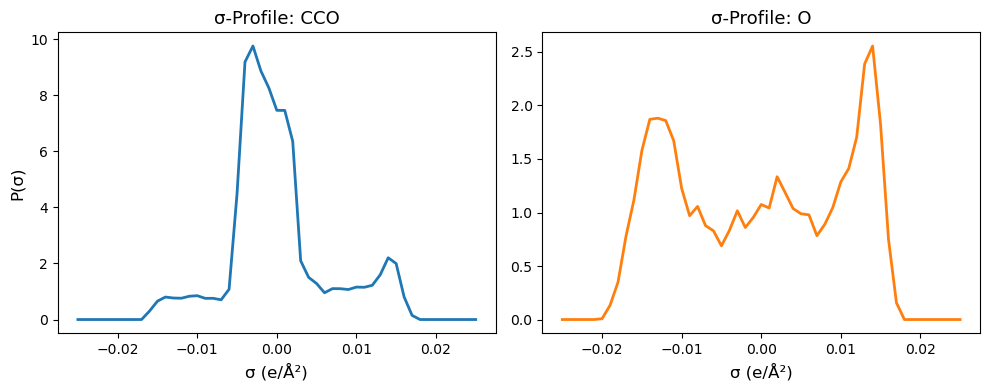

In [7]:
# ==== Input ====
smiles_1 = "CCO"
smiles_2 = "O"
temperature = 300  # K
x1_list = np.linspace(0.0, 1.0, 101)
# ================

ln_gamma_1, ln_gamma_2 = calc_ln_gamma_binary(
    smiles_1, smiles_2, x1_list.tolist(), temperature,
    gamma_predictor=ensemble_predictor,
    get_sigma_profile_fn=sigma_profile_wrapper)

report_binary_result(smiles_1, smiles_2, x1_list, temperature, ln_gamma_1, ln_gamma_2,
                    get_sigma_profile_fn=sigma_profile_wrapper)

## Multicomponent System

**Note:** Provide mole fractions for the first *n − 1* components.  
The last one will be auto-computed as `1 − sum(mole_fractions)`.


In [8]:
# ==== Input ====
smiles_list = ['CO', 'O', 'CC', 'CCCN'] # len = n
mole_fraction_list = [0.3, 0.4, 0.30] # len = n - 1
temperature = 298.15  # K
# ================

lng_array = calc_ln_gamma(
    smiles_list,
    mole_fraction_list,
    temperature,
    gamma_predictor=ensemble_predictor,
    get_sigma_profile_fn=sigma_profile_wrapper
)

df = report_ln_gamma(smiles_list, mole_fraction_list, lng_array, temperature)

=== ln γ at T = 298.15 K ===


,SMILES,Mole Fraction,ln γ
0,CO,0.3,-0.1945
1,O,0.4,0.7531
2,CC,0.3,1.6716
3,CCCN,0.0,-0.9089
